In [1]:
from src import *

from tqdm import tqdm 

import torch
import torch.nn as nn

from torch import optim

from scipy.signal import find_peaks
from scipy import stats

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

### Model Implementation PULSEGAN

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # encoding layers
        self.conv1 = nn.Conv1d(1, 16, 3, stride=1)
        self.conv2 = nn.Conv1d(16, 32, 3, stride=1)
        self.conv3 = nn.Conv1d(32, 64, 3, stride=1)
        self.conv4 = nn.Conv1d(64, 96, 3, stride=1)
        self.conv5 = nn.Conv1d(96, 128, 3, stride=1)
        self.conv6 = nn.Conv1d(128, 156, 3, stride=1)
        

        # decoding layers
        self.deconv6 = nn.ConvTranspose1d(156, 128, kernel_size=3, stride=1)
        self.deconv5 = nn.ConvTranspose1d(128, 96, kernel_size=3, stride=1)
        self.deconv4 = nn.ConvTranspose1d(96, 64, kernel_size=3, stride=1)
        self.deconv3 = nn.ConvTranspose1d(64, 32, kernel_size=3, stride=1)
        self.deconv2 = nn.ConvTranspose1d(32, 16, kernel_size=3, stride=1)
        self.deconv1 = nn.ConvTranspose1d(16, 1, kernel_size=3, stride=1)
        
        # activations
        self.activ1 = nn.PReLU() #not inplace, I want to copy
        self.activ2 = nn.Tanh()
        

    def forward(self, x):
        
        # encoder
        x = self.conv1(x)
        res1 = self.activ1(x)
        
        x = self.conv2(res1)
        res2 = self.activ1(x)
        
        x = self.conv3(res2)
        res3 = self.activ1(x)
        
        x = self.conv4(res3)
        res4 = self.activ1(x)
        
        x = self.conv5(res4)
        res5 = self.activ1(x)
        
        x = self.conv6(res5)
        x = self.activ1(x)   
        
        
        
        # decoder
        x = self.deconv6(x)
        x = self.activ1(x)
        x += res5
        
        x = self.deconv5(x)
        x = self.activ1(x)
        x += res4
        
        x = self.deconv4(x)
        x = self.activ1(x)
        x += res3
        
        x = self.deconv3(x)
        x = self.activ1(x)
        x += res2
        
        x = self.deconv2(x)
        x = self.activ1(x)
        x += res1
        
        x = self.deconv1(x)
        x = self.activ2(x)
        
        
        return x
        
        


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # encoding layers
        self.encode = nn.Sequential(
            nn.Conv1d(2, 8, 3, stride=1),
            nn.BatchNorm1d(8),
            nn.LeakyReLU(0.1),
            nn.Conv1d(8, 12, 3, stride=1),
            nn.BatchNorm1d(12),
            nn.LeakyReLU(0.1),            
            nn.Conv1d(12, 16, 3, stride=1),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.1),            
            nn.Conv1d(16, 20, 3, stride=1),
            nn.BatchNorm1d(20),
            nn.LeakyReLU(0.1),
            nn.Conv1d(20, 24, 3, stride=1),
            nn.BatchNorm1d(24),
            nn.LeakyReLU(0.1),            
           
        )
        
        self.embed = nn.Sequential(
            nn.Conv1d(24, 6, 3, stride=1),
            nn.LeakyReLU(0.1), 
        )
        
        self.head = nn.Sequential(
            nn.Linear(696,128),
            nn.ReLU(),
            nn.Linear(128,24),
            nn.ReLU(),
            nn.Linear(24,1),
            nn.Sigmoid()
        )
        
    def forward(self, X, Xc):
        # concatenate both ground truth or predicted + original signal (used as conditional)
        b, c, l = X.shape
        
        Xi = torch.cat([X,Xc],axis=1)
        
        Xi = self.encode(Xi)
        Xi = self.embed(Xi)
        
        Xi = Xi.reshape(b,-1)
        proba = self.head(Xi)
        
        return proba
        
        
class PulseGan(nn.Module):
    
    def __init__(self):
        super(PulseGan,self).__init__()
        
        self.G = Generator()
        self.D = Discriminator()
        
    
    def forward(self, X, Xc):
        Xrppg = self.G(X)
        
        # Input of original rppg and Ground Truth
        proba_real = self.D(X,Xc)
                
        # Input of original rppg and generator output
        proba_fake = self.D(X,Xrppg)
            
        return X,Xc,Xrppg,proba_fake, proba_real
        

In [5]:
class Gloss(nn.Module):  
    def __init__(self):
        super(Gloss,self).__init__()
        return
    
    def forward(self, rppg_gt, rppg_pred, proba_pred, lbd=.1, beta=.2):
        # accumulating loss for all sample
        loss = 0        
        b, c, l = rppg_gt.shape

        for i in range(b):
            d = proba_pred[i]
            Xc = rppg_gt[i]
            Xg = rppg_pred[i]
            
            
            
            # loss += 1/2 * (d - 1)**2
            
            # loss += lbd * torch.sum(torch.abs(Xc-Xg))

            #loss += beta * torch.sum(self.fft_loss(Xc,Xg))

            loss += beta * self.peak_loss(Xc,Xg)

        return loss
    
    
    def fft_loss(self,Xc,Xg):
        return torch.abs(torch.fft.fft(Xc) - torch.fft.fft(Xg))
        
    def peak_loss(self,Xc,Xg):
        idx_device = Xc.device.index
        d = torch.device("cuda:{}".format(idx_device))
        
        rppgC = Xc.cpu().flatten()
        rppgG = Xg.cpu().flatten().detach()
        peaksC, _ = find_peaks(rppgC, height=0.5) #arbitrary height simply because normalized rppg
        peaksG, _ = find_peaks(rppgG, height=0.5) 
        
        dist = self.min_dist(peaksC, peaksG)
        return dist

    def min_dist(self,I1,I2):
        # NOTE: NOT COMMUTATIVE
        # I1 should be ground truth
        ret = 0 
        if len(I2) == 0:
            I2 = np.zeros_like(I1)
        for val in I1:
            diff = np.min(np.abs(I2-val))
            ret += (diff) # penalize way more large differences 
        return ret
        
        
class Dloss(nn.Module):  
    def __init__(self):
        super(Dloss,self).__init__()
        return
    
    def forward(self, proba_fake, proba_real):      
        # accumulating loss for all sample        
        b = proba_fake.shape[0]
        loss = 0
        
        for i in range(b):
            df = proba_fake[i]
            dr = proba_real[i]
            
            loss += 1/2 * df ** 2 + 1/2 * (dr-1)**2

        return loss

### DataLoader

In [6]:
# # TO AUGMENT SPECIFIC MOTION DATA
# eg = pd.read_csv('../experiments/csvs/phys_pred2.csv')

# intervals = {
#     'exp41':[700, 829], 
#     'exp46':[1620, 1800], 
#     'exp49':[1700, 1900]
# }


# ret = {
#     'id': [],
#     'pred': [],
#     'gt': []
# }

# for exp in intervals.keys():
#     a,b = intervals[exp]
#     roi = eg[eg.id==exp].reset_index(drop=True)
#     roi = roi.iloc[a:b]
    
#     preds = list(roi['pred'])
#     gts = list(roi['gt'])
    
    
#     for i in range(100):
#         ret['id'] += [exp+'_'+str(i)] * len(roi)
#         ret['pred'] += preds
#         ret['gt'] += gts
        
# # new = pd.concat([eg,pd.DataFrame.from_dict(ret)])
# new = pd.DataFrame.from_dict(ret)
# new.to_csv('motionpulse_gan.csv',index=False)

In [7]:
class PulseDataset(Dataset):
    """Dataset of rPPGs"""

    def __init__(self, csv_file, D = 128):
        """
        Args:
            csv_file (string): Path to the csv file with rpp predictions and ground truths
        """
        self.info = pd.read_csv(csv_file)
        self.D = D
        
        exps = self.info.id.unique()
        self.num_samples = sum([len(self.info.loc[self.info.id == exp])//self.D for exp in exps])
        
        # normalize values 
        self.info['pred'] = normalize(self.info['pred'])
        self.info['gt'] = normalize(self.info['gt'])
        
    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        et = np.array(self.info['pred'].iloc[idx*self.D:(idx+1)*self.D])
        gt = np.array(self.info['gt'].iloc[idx*self.D:(idx+1)*self.D])
        et = et.reshape(1,-1)
        gt = gt.reshape(1,-1)
        
        # cast to tensor
        et = torch.from_numpy(et).type(torch.FloatTensor)
        gt = torch.from_numpy(gt).type(torch.FloatTensor)

        return et,gt

In [8]:
train_dataset = PulseDataset('../experiments/csvs/phys_pred2.csv')
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

train, test = torch.utils.data.random_split(trainloader.dataset, [len(trainloader.dataset)//2, 
                                                                 len(trainloader.dataset)//2])

trainloader = torch.utils.data.DataLoader(train, batch_size=3, shuffle=False)
testloader = torch.utils.data.DataLoader(test, batch_size=3, shuffle=False)

dataloaders = {
    'train': trainloader,
    'test': testloader
}

### Model Training

In [24]:
model = PulseGan()
model = model.to(device)

# PATH = './checkpoints/PulseGan2_49.pt'
# model.load_state_dict(torch.load(PATH))

criterion_G = Gloss() 
criterion_D = Dloss()

optimizer = optim.Adam(model.parameters(), lr=0.0001)


val_loss_history = []
train_loss_history = []

num_epochs = 50

for epoch in tqdm(range(num_epochs)):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    phases = ['train', 'test']
    for phase in phases:
        running_loss = 0.0
        if phase == 'train':
            model.train()  # Set model to training mode -> activate droput layers and batch norm
        else:
            model.eval()  # Set model to evaluate mode

        # Iterate over data.
        for inputs, targets in dataloaders[phase]:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                X,Xc,Xrppg, proba_fake, proba_real = model(inputs,targets)
                
                loss = criterion_G(Xc, Xrppg, proba_fake) + criterion_D(proba_fake, proba_real)
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    print(torch.sum(model.G.conv1.weight.grad))
                    optimizer.step()
                    
            # statistics
            running_loss += loss.item()

        epoch_loss = running_loss / len(dataloaders[phase])
        print('{} Loss: {:.4f} '.format(phase, epoch_loss))

        if phase == 'test':
            val_loss_history.append(epoch_loss)
        else:
            train_loss_history.append(epoch_loss)

    torch.save(model.state_dict(), f'checkpoints/PulseGan3_{epoch}.pt')


  0%|                                                                                          | 0/50 [00:00<?, ?it/s]

Epoch 0/49
----------
tensor(0.0234, device='cuda:1')
tensor(-0.0743, device='cuda:1')
tensor(0.1206, device='cuda:1')
tensor(-0.0021, device='cuda:1')
tensor(-0.1285, device='cuda:1')
tensor(0.0246, device='cuda:1')
tensor(0.0382, device='cuda:1')
tensor(-0.0018, device='cuda:1')
tensor(-0.0075, device='cuda:1')
tensor(-0.0245, device='cuda:1')
tensor(0.0204, device='cuda:1')
tensor(-0.1357, device='cuda:1')
tensor(0.1360, device='cuda:1')
tensor(0.0730, device='cuda:1')
tensor(-0.0198, device='cuda:1')
tensor(-0.1040, device='cuda:1')
tensor(-0.0134, device='cuda:1')
tensor(0.0175, device='cuda:1')
tensor(0.0108, device='cuda:1')
tensor(-0.0965, device='cuda:1')
tensor(-0.1338, device='cuda:1')
tensor(0.0200, device='cuda:1')
tensor(0.0848, device='cuda:1')
tensor(-0.0622, device='cuda:1')
tensor(0.0418, device='cuda:1')
tensor(-0.1093, device='cuda:1')
tensor(-0.0962, device='cuda:1')
tensor(-0.0813, device='cuda:1')
tensor(0.0491, device='cuda:1')
tensor(0.0067, device='cuda:1')
te


  2%|█▋                                                                                | 1/50 [00:02<01:54,  2.34s/it]

test Loss: 4.3989 
Epoch 1/49
----------
tensor(-0.0466, device='cuda:1')
tensor(0.0706, device='cuda:1')
tensor(-0.0634, device='cuda:1')
tensor(0.0787, device='cuda:1')
tensor(0.0988, device='cuda:1')
tensor(-0.1149, device='cuda:1')
tensor(-0.1962, device='cuda:1')
tensor(-0.0200, device='cuda:1')
tensor(-0.0168, device='cuda:1')
tensor(-0.1828, device='cuda:1')
tensor(-0.0935, device='cuda:1')
tensor(0.0397, device='cuda:1')
tensor(-0.1368, device='cuda:1')
tensor(0.2060, device='cuda:1')
tensor(-0.0857, device='cuda:1')
tensor(-0.2954, device='cuda:1')
tensor(-0.0978, device='cuda:1')
tensor(0.1871, device='cuda:1')
tensor(-0.3209, device='cuda:1')
tensor(0.3294, device='cuda:1')
tensor(0.1604, device='cuda:1')
tensor(-0.0780, device='cuda:1')
tensor(0.1306, device='cuda:1')
tensor(0.0174, device='cuda:1')
tensor(-0.0617, device='cuda:1')
tensor(0.2473, device='cuda:1')
tensor(0.0747, device='cuda:1')
tensor(0.1072, device='cuda:1')
tensor(0.2234, device='cuda:1')
tensor(-0.0426, 


  4%|███▎                                                                              | 2/50 [00:04<01:50,  2.31s/it]

test Loss: 4.8428 
Epoch 2/49
----------
tensor(-0.1518, device='cuda:1')
tensor(-0.4037, device='cuda:1')
tensor(0.0665, device='cuda:1')
tensor(0.1000, device='cuda:1')
tensor(-0.3869, device='cuda:1')
tensor(0.6785, device='cuda:1')
tensor(-1.8758, device='cuda:1')
tensor(1.4685, device='cuda:1')
tensor(0.2091, device='cuda:1')
tensor(-0.1320, device='cuda:1')
tensor(-0.1493, device='cuda:1')
tensor(0.1929, device='cuda:1')
tensor(0.1351, device='cuda:1')
tensor(1.1573, device='cuda:1')
tensor(0.2140, device='cuda:1')
tensor(0.2945, device='cuda:1')
tensor(0.0977, device='cuda:1')
tensor(0.2490, device='cuda:1')
tensor(0.9372, device='cuda:1')
tensor(0.4538, device='cuda:1')
tensor(-0.7219, device='cuda:1')
tensor(-0.2956, device='cuda:1')
tensor(-0.0590, device='cuda:1')
tensor(-1.4257, device='cuda:1')
tensor(-0.5703, device='cuda:1')
tensor(-0.0218, device='cuda:1')
tensor(-0.1934, device='cuda:1')
tensor(0.5188, device='cuda:1')
tensor(0.0345, device='cuda:1')
tensor(-0.3343, de


  6%|████▉                                                                             | 3/50 [00:06<01:48,  2.30s/it]

test Loss: 8.0453 
Epoch 3/49
----------
tensor(0.1251, device='cuda:1')
tensor(0.5965, device='cuda:1')
tensor(0.8128, device='cuda:1')
tensor(0.0873, device='cuda:1')
tensor(0.0457, device='cuda:1')
tensor(0.0806, device='cuda:1')
tensor(-0.0122, device='cuda:1')
tensor(0.0488, device='cuda:1')
tensor(-1.0687, device='cuda:1')
tensor(0.0129, device='cuda:1')
tensor(0.0638, device='cuda:1')
tensor(0.0726, device='cuda:1')
tensor(0.0339, device='cuda:1')
tensor(0.0384, device='cuda:1')
tensor(0.0302, device='cuda:1')
tensor(0.0669, device='cuda:1')
tensor(-0.0645, device='cuda:1')
tensor(-0.0290, device='cuda:1')
tensor(0.2668, device='cuda:1')
tensor(0.0244, device='cuda:1')
tensor(0.0068, device='cuda:1')
tensor(0.0501, device='cuda:1')
tensor(0.0091, device='cuda:1')
tensor(0.0353, device='cuda:1')
tensor(0.1462, device='cuda:1')
tensor(0.0282, device='cuda:1')
tensor(0.0473, device='cuda:1')
tensor(0.0179, device='cuda:1')
tensor(-0.0067, device='cuda:1')
tensor(0.2164, device='cud


  8%|██████▌                                                                           | 4/50 [00:09<01:45,  2.30s/it]

test Loss: 64.8366 
Epoch 4/49
----------
tensor(0.0088, device='cuda:1')
tensor(0.0334, device='cuda:1')
tensor(-0.0190, device='cuda:1')
tensor(-0.0004, device='cuda:1')
tensor(0.0085, device='cuda:1')
tensor(0.0045, device='cuda:1')
tensor(-0.1080, device='cuda:1')
tensor(0.0116, device='cuda:1')
tensor(0.1879, device='cuda:1')
tensor(0.0074, device='cuda:1')
tensor(-0.0013, device='cuda:1')
tensor(0.0256, device='cuda:1')
tensor(0.0185, device='cuda:1')
tensor(-0.0046, device='cuda:1')
tensor(-0.0110, device='cuda:1')
tensor(0.0334, device='cuda:1')
tensor(-0.0202, device='cuda:1')
tensor(-0.0243, device='cuda:1')
tensor(0.0750, device='cuda:1')
tensor(0.0001, device='cuda:1')
tensor(-0.0007, device='cuda:1')
tensor(0.0196, device='cuda:1')
tensor(-0.0010, device='cuda:1')
tensor(-0.0031, device='cuda:1')
tensor(0.0278, device='cuda:1')
tensor(0.0049, device='cuda:1')
tensor(0.0029, device='cuda:1')
tensor(0.0048, device='cuda:1')
tensor(-0.0077, device='cuda:1')
tensor(0.0469, dev


 10%|████████▏                                                                         | 5/50 [00:11<01:44,  2.32s/it]

test Loss: 80.2666 
Epoch 5/49
----------
tensor(0.0062, device='cuda:1')
tensor(0.0161, device='cuda:1')
tensor(-0.0009, device='cuda:1')
tensor(0.0035, device='cuda:1')
tensor(0.0055, device='cuda:1')
tensor(0.0051, device='cuda:1')
tensor(-0.0291, device='cuda:1')
tensor(0.0050, device='cuda:1')
tensor(0.1266, device='cuda:1')
tensor(0.0028, device='cuda:1')
tensor(0.0002, device='cuda:1')
tensor(0.0165, device='cuda:1')
tensor(0.0072, device='cuda:1')
tensor(-0.0107, device='cuda:1')
tensor(0.0048, device='cuda:1')
tensor(0.0265, device='cuda:1')
tensor(-0.0109, device='cuda:1')
tensor(-0.0188, device='cuda:1')
tensor(0.0227, device='cuda:1')
tensor(-0.0016, device='cuda:1')
tensor(-0.0035, device='cuda:1')
tensor(0.0055, device='cuda:1')
tensor(-0.0009, device='cuda:1')
tensor(-0.0011, device='cuda:1')
tensor(0.0041, device='cuda:1')
tensor(0.0006, device='cuda:1')
tensor(-0.0042, device='cuda:1')
tensor(0.0020, device='cuda:1')
tensor(-0.0097, device='cuda:1')
tensor(0.0206, devi

 10%|████████▏                                                                         | 5/50 [00:13<02:02,  2.72s/it]


KeyboardInterrupt: 

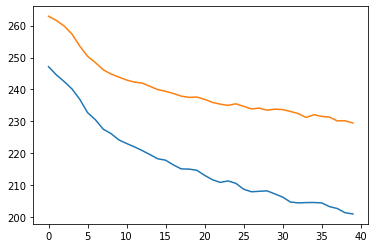

In [70]:
plt.plot(train_loss_history[10:])
plt.plot(val_loss_history[10:])

### Examples of usage and results

In [71]:
X,Xc = next(iter(testloader))

In [72]:
inputs = X.to(device)
targets = Xc.to(device)

In [73]:
X,Xc,Xrppg, _, _ = model(inputs,targets)

In [74]:
original = X.cpu().numpy()
ground_truth = Xc.cpu().numpy()
corrected = Xrppg.cpu().detach().numpy()

Text(0.5, 0.98, 'Illustration of PULSE GAN correction')

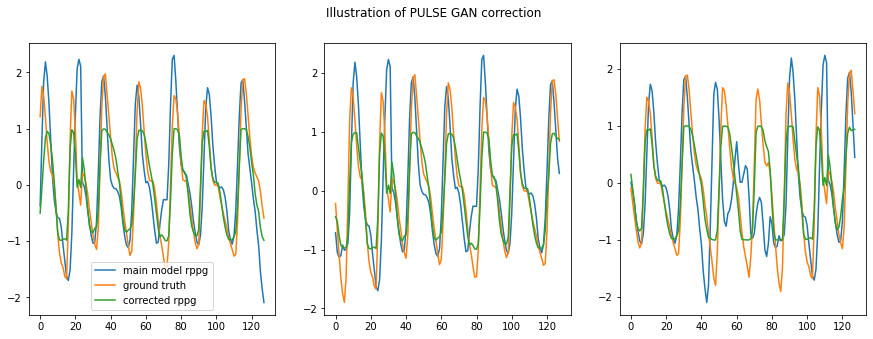

In [75]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(original[0,0],label='main model rppg')
ax[0].plot(ground_truth[0,0],label='ground truth')
ax[0].plot(corrected[0,0],label='corrected rppg')

ax[1].plot(original[1,0],label='main model rppg')
ax[1].plot(ground_truth[1,0],label='ground truth')
ax[1].plot(corrected[1,0],label='corrected rppg')

ax[2].plot(original[2,0],label='main model rppg')
ax[2].plot(ground_truth[2,0],label='ground truth')
ax[2].plot(corrected[2,0],label='corrected rppg')


ax[0].legend()
fig.suptitle('Illustration of PULSE GAN correction')

In [76]:
eg = pd.read_csv('exp46.csv')
eg['pred'] = normalize(eg['pred'])
eg['gt'] = normalize(eg['gt'])

<AxesSubplot:>

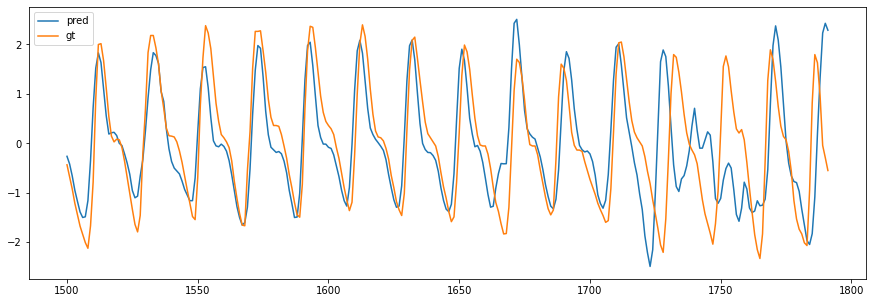

In [77]:
eg.iloc[1500:].plot(figsize=(15,5))

In [91]:
model = PulseGan()
model = model.to(device)

model.load_state_dict(torch.load('./checkpoints/PulseGan3_49.pt'))

<All keys matched successfully>

In [83]:
INPUTS = []
TARGETS = []
for i in range(14):
    preds = np.array(eg['pred'].iloc[i*128:(i+1)*128])
    gts = np.array(eg['gt'].iloc[i*128:(i+1)*128])
    
    preds = torch.from_numpy(preds).type(torch.FloatTensor)
    gts = torch.from_numpy(gts).type(torch.FloatTensor)
    INPUTS.append(preds)
    TARGETS.append(gts)

In [84]:
# Iterate over data.

originals = []
ground_truths = []
correcteds = []

for inputs, targets in zip(INPUTS, TARGETS):
    
    if inputs.shape[-1] < 128: break
        
    inputs = inputs.reshape(1,1,-1)
    targets = targets.reshape(1,1,-1)
    inputs = inputs.to(device)
    targets = targets.to(device)

    # forward
    # track history if only in train
    with torch.no_grad():
        X,Xc,Xrppg, proba_fake, proba_real = model(inputs,targets)
        
        
    original = inputs.cpu().numpy()
    ground_truth = targets.cpu().numpy()
    corrected = Xrppg.cpu().detach().numpy()
    
    originals.append(original)
    ground_truths.append(ground_truth)
    correcteds.append(corrected)

originals = np.concatenate(originals).flatten()
correcteds = np.concatenate(correcteds).flatten()
ground_truths = np.concatenate(ground_truths).flatten()

Text(0.5, 0.98, 'PULSE GAN correction on ROI motion with L1-match')

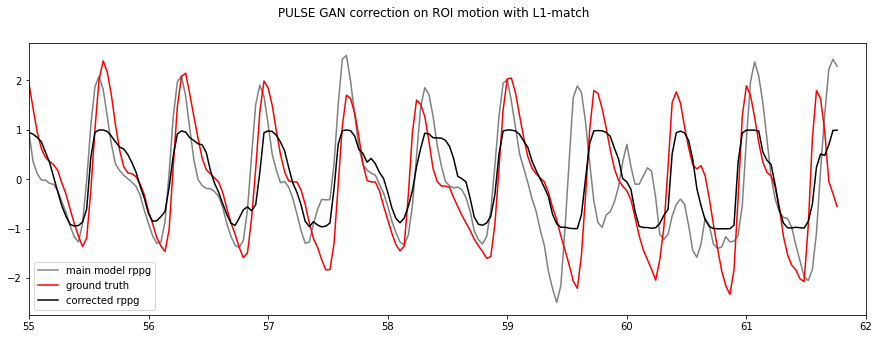

In [85]:
fig,ax = plt.subplots(1,figsize=(15,5))

N = len(originals)


ax.plot(np.array(range(N))/29,originals,label='main model rppg',color='grey')
ax.plot(np.array(range(N))/29,ground_truths,label='ground truth',color='red')
ax.plot(np.array(range(N))/29,correcteds,label='corrected rppg',color='black')


ax.legend()
ax.set_xlim(55,62)

fig.suptitle('PULSE GAN correction on ROI motion with L1-match')

### Compute correlation again for Physnet with correcting

In [86]:
eg = pd.read_csv('../experiments/csvs/phys_pred2.csv')

In [92]:
model.G()

Generator(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (conv4): Conv1d(64, 96, kernel_size=(3,), stride=(1,))
  (conv5): Conv1d(96, 128, kernel_size=(3,), stride=(1,))
  (conv6): Conv1d(128, 156, kernel_size=(3,), stride=(1,))
  (deconv6): ConvTranspose1d(156, 128, kernel_size=(3,), stride=(1,))
  (deconv5): ConvTranspose1d(128, 96, kernel_size=(3,), stride=(1,))
  (deconv4): ConvTranspose1d(96, 64, kernel_size=(3,), stride=(1,))
  (deconv3): ConvTranspose1d(64, 32, kernel_size=(3,), stride=(1,))
  (deconv2): ConvTranspose1d(32, 16, kernel_size=(3,), stride=(1,))
  (deconv1): ConvTranspose1d(16, 1, kernel_size=(3,), stride=(1,))
  (activ1): PReLU(num_parameters=1)
  (activ2): Tanh()
)

In [100]:
Xrppg

tensor([[[-0.8561, -0.9232, -0.9610, -0.9456, -0.8834, -0.1844,  0.7081,
           0.9840,  0.9986,  0.9845,  0.8769,  0.6075,  0.5246,  0.3487,
           0.4243,  0.3177,  0.1402,  0.0182, -0.2538, -0.5724, -0.7897,
          -0.8779, -0.7846, -0.5494, -0.2307,  0.2559,  0.6254,  0.9330,
           0.9190,  0.8416,  0.8377,  0.8337,  0.7903,  0.6682,  0.4204,
           0.0630,  0.0126, -0.0523, -0.3816, -0.7622, -0.9074, -0.9277,
          -0.8822, -0.7490, -0.3100,  0.5105,  0.9774,  0.9990,  0.9971,
           0.9776,  0.9094,  0.7729,  0.6486,  0.3702,  0.1803,  0.0061,
          -0.1639, -0.3513, -0.7080, -0.8981, -0.9694, -0.9678, -0.9877,
          -0.9966, -0.9951, -0.7126,  0.0204,  0.7281,  0.9817,  0.9862,
           0.9822,  0.9475,  0.8685,  0.6284,  0.4094,  0.0170, -0.0519,
          -0.2035, -0.6461, -0.9499, -0.9724, -0.9755, -0.9884, -0.9782,
          -0.8902, -0.7263, -0.6072,  0.5137,  0.9441,  0.9746,  0.9406,
           0.7834,  0.3989, -0.1910, -0.5312, -0.81

In [101]:
ret = {
    'id': [],
    'pred': [],
    'gt': [],
    'corrected': []
}
for exp in eg.id.unique():
    interest = eg[eg.id==exp]
    for i in range(len(interest)//128):
        
        X = np.array(interest['pred'].iloc[i*128:(i+1)*128])
        X = torch.from_numpy(X).type(torch.FloatTensor)
        X = X.reshape(1,1,-1)
        X = X.to(device)
        
        Xrppg = model.G(X).cpu().detach().numpy().flatten()
        
        ret['id'] += [exp] * 128
        ret['pred'] += list(X.flatten().cpu().detach().numpy())
        ret['gt'] += list(interest['gt'].iloc[i*128:(i+1)*128])
        ret['corrected'] += list(Xrrpg)

In [103]:
corrected_df = pd.DataFrame.from_dict(ret)

In [108]:
ret = {
    'id': [],
    'corr': []
}
for exp in corrected_df.id.unique():
    interest = corrected_df[corrected_df.id==exp]
    Xc = interest['gt']
    Xrppg = interest['corrected']
    
    
    corr, _ = stats.pearsonr(Xc, Xrppg)
    ret['id'].append(exp)
    ret['corr'].append(corr)

In [110]:
pd.DataFrame.from_dict(ret).mean()

/tmp/ipykernel_1948383/2229763696.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd.DataFrame.from_dict(ret).mean()


corr    0.627004
dtype: float64